# Real Estate Recommender System "HomeMatch"

## Project Summary

This project aims to develop a personalized real estate recommender system utilizing a Large Language Model (LLM). Various AI technologies are integrated to generate, store, and search real estate listings based on user preferences. The project is structured into several key tasks:

### **Generating Real Estate Listings with an LLM**

**Objective**  
To generate a minimum of 10 diverse and realistic real estate listings containing factual information using a Large Language Model.

**Methodology**  
- **Synthetic Database Creation:**  
  - A Large Language Model was employed to generate 10 diverse and realistic real estate listings.
  - Each listing encompasses details such as neighborhood, price, number of bedrooms, number of bathrooms, house size, and descriptions of the house and neighborhood.
  
- **Integration of Real Dataset:**  
  - A real dataset titled "House Price Estimation from Visual and Textual Features" by H. Ahmed E. and Moustafa M. (2016) was incorporated.
  - Four images were randomly assigned to each listing from this dataset to develop a multimodal recommender system.

### **Creating a Vector Database and Storing Listings**

**Objective**  
To create a vector database and store real estate listing embeddings generated from the LLM-created listings.

**Methodology**  
- **Vector Database Creation:**  
  - A vector database was established to store embeddings of the listings.
  - Embedding techniques were utilized to convert textual and visual features of listings into embeddings.
  
- **Storage and Organization:**  
  - The embeddings were successfully stored and organized within the vector database for efficient retrieval.

### **Semantic Search of Listings Based on Buyer Preferences**

**Objective**  
To implement a functionality that enables semantic search of listings based on buyer preferences.

**Methodology**  
- **Buyer Preferences Collection:**  
  - Buyer preferences were collected to tailor the search functionality.
  
- **Semantic Search Implementation:**  
  - Semantic search algorithms were developed to match buyer preferences with the stored listings.
  - The search functionality returns listings that closely align with the input preferences.

### **Augmented Response Generation**

**Objective**  
To enhance real estate listings based on buyer preferences by implementing logic for searching and augmenting listing descriptions.

**Methodology**  
- **Search and Augment Descriptions:**  
  - A logical flow was formulated where buyer preferences are used to search and augment real estate listings.
  - It was ensured that augmentations personalize the listings without altering factual information.
  
- **Use of LLM:**  
  - The LLM was leveraged to generate personalized descriptions for real estate listings based on buyer preferences.
  - The descriptions were ensured to be unique, appealing, and tailored to the provided preferences.

### **Web UI for Demonstration**

**Objective**  
To create a web-based user interface to demonstrate the basic functionality of the recommender system.

**Methodology**  
- **Web UI Development:**  
  - A web UI using Gradio was developed to showcase the system's functionalities.
  - Features for inputting buyer preferences, viewing personalized listings, and searching through the database were included.




In [1]:
#!pip install --upgrade openai

### Setting Up the Python Application

#### Initialize a Python Project: Create a new Python project, setting up a virtual environment and installing necessary packages

In [2]:
import pandas as pd
import numpy as np
import io
import os
import requests

In [3]:

import openai
from openai import OpenAI

In [4]:
#import tiktoken
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [5]:
# Assuming OpenAI and necessary functions are defined elsewhere
client = OpenAI()
COMPLETION_MODEL_NAME = "gpt-3.5-turbo"

In [6]:
from transformers import CLIPModel, CLIPProcessor

MODEL_ID = "openai/clip-vit-base-patch32"
device = "cpu"

model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)


In [7]:
#from pydantic import BaseModel
#from typing import List

#class Image(BaseModel):
   # image_url: str
    #label: str
    #image_vector: List[float]
    #text_vector: List[float]

### **1) Generating Real Estate Listings with an LLM**

### Synthetic Data Generation

In [8]:
import PIL.Image
from pydantic import BaseModel
from typing import Optional
from IPython.display import Image, display
import requests
from PIL import Image as PILImage
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel

Generate real estate listings using a Large Language Model. Generate at least 10 listings This can involve creating prompts for the LLM to produce descriptions of various properties. 

In [9]:
#This code defines a class Image using Pydantic, a library for data validation and settings management using Python type annotations.
#The Image class includes methods for converting between a PIL image and bytes.

class Image(BaseModel):
    """
    A class representing an image with associated metadata and methods for 
    converting between different formats.

    Attributes:
        image_url (str): A URL pointing to the image.
        image (bytes): The image data in bytes.
        label (Optional[int]): An optional label for the image.
        vector (Optional[list]): An optional list representing the vector embedding of the image.
    """

    image_url: str
    image: bytes
    label: Optional[int] = None
    vector: Optional[list] = None

    def to_pil(self):
        """
        Converts the image bytes to a PIL image.

        Returns:
            PIL.Image.Image: The PIL image object created from the bytes.
        """
        return PIL.Image.open(io.BytesIO(self.image))

    @classmethod
    def pil_to_bytes(cls, img) -> bytes:
        """
        Converts a PIL image to bytes in PNG format.

        Args:
            img (PIL.Image.Image): The PIL image to be converted.

        Returns:
            bytes: The image data in bytes.
        """
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return buf.getvalue()


In [10]:
def create_listings_dataframe():
    """
    Create a DataFrame containing real estate listings data.

    Each listing includes details such as neighborhood, price, number of bedrooms,
    number of bathrooms, house size, a description of the house, and a description
    of the neighborhood.

    Returns:
        pd.DataFrame: A DataFrame containing the real estate listings.
    """
    # Define the data as a list of dictionaries
    listings_data = [
        {
            "Neighborhood": "Lakeview Heights", 
            "Price": 950000, 
            "Bedrooms": 4, 
            "Bathrooms": 3, 
            "House Size": 2500,
            "Description": "Discover luxury and serenity in Lakeview Heights. This 4-bedroom, 3-bathroom residence offers panoramic lake views, a modern kitchen with high-end appliances, and a grand master suite. The landscaped garden, complete with a deck and fire pit, provides a perfect setting for outdoor entertainment.",
            "Neighborhood Description": "Lakeview Heights is renowned for its breathtaking lake scenery, exclusive golf courses, and gourmet restaurants. Enjoy waterfront walks, boating, and a vibrant community life in this prestigious neighborhood."
        },
        {
            "Neighborhood": "Sunset Trails", 
            "Price": 725000, 
            "Bedrooms": 3, 
            "Bathrooms": 2.5, 
            "House Size": 1800,
            "Description": "Embrace the charm of Sunset Trails in this beautifully designed 3-bedroom home. Features include a cozy fireplace, hardwood flooring, and a gourmet kitchen that opens to a private patio. The master suite offers a spa-like bathroom and walk-in closet.",
            "Neighborhood Description": "Sunset Trails boasts a friendly community atmosphere, with parks, hiking trails, and excellent schools. It’s an ideal place for outdoor enthusiasts and families looking for a peaceful suburban life."
        },
        {
            "Neighborhood": "Orchard Valley", 
            "Price": 1200000, 
            "Bedrooms": 5, 
            "Bathrooms": 4, 
            "House Size": 3500,
            "Description": "Experience grand living in Orchard Valley with this spacious 5-bedroom estate. The home features a stunning entryway, chef’s kitchen, and a luxurious master suite. The expansive backyard includes a pool and outdoor kitchen, perfect for entertaining.",
            "Neighborhood Description": "Known for its upscale homes and lush landscapes, Orchard Valley is a premier neighborhood with top-tier schools, shopping centers, and gourmet dining options."
        },
        {
            "Neighborhood": "Coastal Haven", 
            "Price": 1500000, 
            "Bedrooms": 4, 
            "Bathrooms": 3.5, 
            "House Size": 3000,
            "Description": "This exquisite 4-bedroom beachfront home in Coastal Haven offers unobstructed ocean views, open-plan living areas, and high-quality finishes. The master suite has a private balcony overlooking the sea, and the property includes direct beach access.",
            "Neighborhood Description": "Coastal Haven is a serene beach community with a laid-back lifestyle, pristine beaches, and local seafood restaurants. It’s perfect for those seeking a tranquil coastal retreat."
        },
        {
            "Neighborhood": "Modern Metro", 
            "Price": 850000, 
            "Bedrooms": 2, 
            "Bathrooms": 2, 
            "House Size": 1200,
            "Description": "This modern loft in the heart of Modern Metro offers sleek design, state-of-the-art amenities, and floor-to-ceiling windows with city views. The open layout includes a contemporary kitchen and a luxurious master suite.",
            "Neighborhood Description": "Modern Metro is a vibrant urban neighborhood with a mix of residential lofts, art galleries, trendy cafes, and nightlife. It’s perfect for those who love the energy of city living."
        },
        {
            "Neighborhood": "Countryside Meadows", 
            "Price": 980000, 
            "Bedrooms": 4, 
            "Bathrooms": 3, 
            "House Size": 2800,
            "Description": "This elegant 4-bedroom home in Countryside Meadows features a two-story foyer, formal dining room, and a family room with a stone fireplace. The large kitchen leads to a beautiful sunroom overlooking the gardens.",
            "Neighborhood Description": "Countryside Meadows offers a blend of rural charm and modern conveniences, with open spaces, community farms, and quaint boutiques, creating a warm and inviting community atmosphere."
        },
        {
            "Neighborhood": "Riverbend Estates", 
            "Price": 1100000, 
            "Bedrooms": 5, 
            "Bathrooms": 4.5, 
            "House Size": 4000,
            "Description": "Discover the beauty of Riverbend Estates with this luxurious 5-bedroom home. It boasts an impressive two-story living room, a gourmet kitchen, and a master suite with a private terrace. The property includes a large deck and a landscaped yard that backs onto a peaceful river.",
            "Neighborhood Description": "Riverbend Estates is an exclusive community nestled along the riverbanks, known for its scenic views, privacy, and luxury homes. Residents enjoy boating, fishing, and nature walks in this picturesque setting."
        },
        {
            "Neighborhood": "Skyline Ridge", 
            "Price": 1300000, 
            "Bedrooms": 4, 
            "Bathrooms": 3.5, 
            "House Size": 3200,
            "Description": "Perched atop Skyline Ridge, this stunning 4-bedroom home features breathtaking city and mountain views, an open-concept floor plan, and a gourmet kitchen. The master suite includes a walk-in closet and spa-like bathroom.",
            "Neighborhood Description": "Skyline Ridge is an affluent neighborhood known for its spectacular views, luxury homes, and exclusive amenities. It’s a haven for those seeking a prestigious and private living environment."
        },
        {
            "Neighborhood": "Cedar Heights", 
            "Price": 1200000, 
            "Bedrooms": 4, 
            "Bathrooms": 3, 
            "House Size": 3600,
            "Description": "Immerse yourself in the luxury of Cedar Heights with this stunning 4-bedroom, 3-bathroom home. Featuring vaulted ceilings, a chef's kitchen, and an expansive living area with a stone fireplace, this property exudes elegance. The master suite offers a spa-like retreat, and the outdoor living space includes a custom pool and lush landscaping.",
            "Neighborhood Description": "Cedar Heights is an exclusive enclave known for its scenic hilltop views and luxurious homes. The community prides itself on its secluded feel, yet is conveniently located near high-end shopping, fine dining, and renowned schools."
        },
        {
            "Neighborhood": "Brookstone Park", 
            "Price": 900000, 
            "Bedrooms": 3, 
            "Bathrooms": 2.5, 
            "House Size": 2900,
            "Description": "Discover the charm of Brookstone Park in this exquisite 3-bedroom, 2.5-bathroom residence. The home features an open floor plan with a modern kitchen, spacious living areas, and a home office. The beautifully landscaped yard and patio provide a serene setting for outdoor relaxation.",
            "Neighborhood Description": "Brookstone Park offers a perfect blend of suburban tranquility and urban convenience. With its beautiful parks, community center, and easy access to city amenities, it's a sought-after location for those desiring a balanced lifestyle."
        }
        # Assume more entries are added here
    ]

    # Convert the list of dictionaries into a DataFrame
    listings_df = pd.DataFrame(listings_data)
    
    return listings_df
# Create the DataFrame
listings_df = create_listings_dataframe()

# Example usage: Display the DataFrame
listings_df


Neighborhood    Price  Bedrooms  Bathrooms  House Size  \
0     Lakeview Heights   950000         4        3.0        2500   
1        Sunset Trails   725000         3        2.5        1800   
2       Orchard Valley  1200000         5        4.0        3500   
3        Coastal Haven  1500000         4        3.5        3000   
4         Modern Metro   850000         2        2.0        1200   
5  Countryside Meadows   980000         4        3.0        2800   
6    Riverbend Estates  1100000         5        4.5        4000   
7        Skyline Ridge  1300000         4        3.5        3200   
8        Cedar Heights  1200000         4        3.0        3600   
9      Brookstone Park   900000         3        2.5        2900   

                                         Description  \
0  Discover luxury and serenity in Lakeview Heigh...   
1  Embrace the charm of Sunset Trails in this bea...   
2  Experience grand living in Orchard Valley with...   
3  This exquisite 4-bedroom beachfront home in Co...   
4  This modern loft in the heart of Modern Metro ...   
5  This elegant 4-bedroom home in Countryside Mea...   
6  Discover the beauty of Riverbend Estates with ...   
7  Perched atop Skyline Ridge, this stunning 4-be...   
8  Immerse yourself in the luxury of Cedar Height...   
9  Discover the charm of Brookstone Park in this ...   

                            Neighborhood Description  
0  Lakeview Heights is renowned for its breathtak...  
1  Sunset Trails boasts a friendly community atmo...  
2  Known for its upscale homes and lush landscape...  
3  Coastal Haven is a serene beach community with...  
4  Modern Metro is a vibrant urban neighborhood w...  
5  Countryside Meadows offers a blend of rural ch...  
6  Riverbend Estates is an exclusive community ne...  
7  Skyline Ridge is an affluent neighborhood know...  
8  Cedar Heights is an exclusive enclave known fo...  
9  Brookstone Park offers a perfect blend of subu...

In [11]:
# Adding a unique identifier
#listings_df['id'] = range(len(listings_df))
#listings_df.set_index('id', inplace=True)


In [12]:
listings_df

Neighborhood    Price  Bedrooms  Bathrooms  House Size  \
0     Lakeview Heights   950000         4        3.0        2500   
1        Sunset Trails   725000         3        2.5        1800   
2       Orchard Valley  1200000         5        4.0        3500   
3        Coastal Haven  1500000         4        3.5        3000   
4         Modern Metro   850000         2        2.0        1200   
5  Countryside Meadows   980000         4        3.0        2800   
6    Riverbend Estates  1100000         5        4.5        4000   
7        Skyline Ridge  1300000         4        3.5        3200   
8        Cedar Heights  1200000         4        3.0        3600   
9      Brookstone Park   900000         3        2.5        2900   

                                         Description  \
0  Discover luxury and serenity in Lakeview Heigh...   
1  Embrace the charm of Sunset Trails in this bea...   
2  Experience grand living in Orchard Valley with...   
3  This exquisite 4-bedroom beachfront home in Co...   
4  This modern loft in the heart of Modern Metro ...   
5  This elegant 4-bedroom home in Countryside Mea...   
6  Discover the beauty of Riverbend Estates with ...   
7  Perched atop Skyline Ridge, this stunning 4-be...   
8  Immerse yourself in the luxury of Cedar Height...   
9  Discover the charm of Brookstone Park in this ...   

                            Neighborhood Description  
0  Lakeview Heights is renowned for its breathtak...  
1  Sunset Trails boasts a friendly community atmo...  
2  Known for its upscale homes and lush landscape...  
3  Coastal Haven is a serene beach community with...  
4  Modern Metro is a vibrant urban neighborhood w...  
5  Countryside Meadows offers a blend of rural ch...  
6  Riverbend Estates is an exclusive community ne...  
7  Skyline Ridge is an affluent neighborhood know...  
8  Cedar Heights is an exclusive enclave known fo...  
9  Brookstone Park offers a perfect blend of subu...

In [53]:
# Save DataFrame to a text file
listings_df.to_csv('listings.txt', sep='\t', index=False)

In [13]:
#!pip install ipython pillow


In [14]:
# Define base URL and image paths for each listing
#base_url = 'https://github.com/emanhamed/Houses-dataset/raw/master/'
#image_nums = list(range(100, 113))  # Adjusted range to cover 100 to 112 with 4 images per description
#image_paths = {num: [f"{base_url}{num}_{i}_bathroom.jpg" for i in range(1, 5)] for num in image_nums}


The CLIP (Contrastive Language-Image Pretraining) library is a general tool developed by OpenAI that bridges the gap between natural language and vision models. CLIP is designed to understand images in the context of natural language, enabling a wide range of applications that require interpreting visual data alongside textual descriptions.
CLIP Initialization:

model and processor are initialized using pre-trained models from Hugging Face's transformers library.
Image URLs Generation:

base_url is the base URL where images are stored.
property_ids is a range of property IDs (100 to 109).
image_types is a list of image types.
image_urls is a dictionary where each key is a property ID and each value is a list of URLs for the different image types of that property.

In [15]:
# Initialize CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Assuming each property from 100 to 110 has 4 types of images
base_url = 'https://raw.githubusercontent.com/emanhamed/Houses-dataset/master/Houses%20Dataset/'
property_ids = range(100, 110)  # Adjusted to include 109
image_types = ['bathroom', 'bedroom', 'frontal', 'kitchen']

# Generate a dictionary with property IDs as keys and lists of image URLs as values
image_urls = {prop_id: [f"{base_url}{prop_id}_{img_type}.jpg" for img_type in image_types] for prop_id in property_ids}




Displaying images for property ID: 108


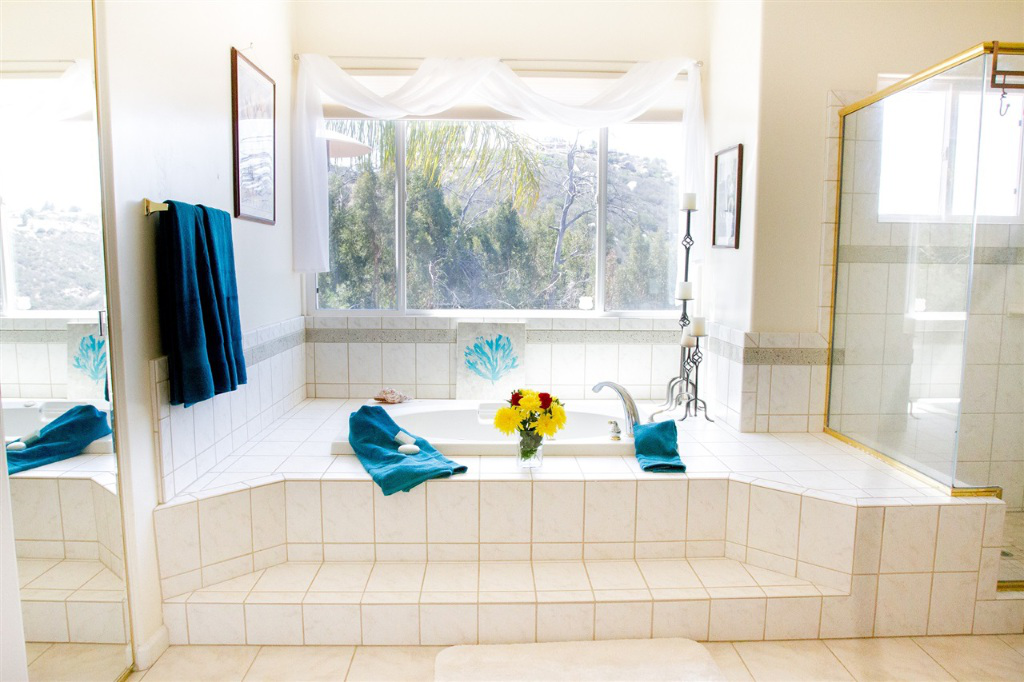

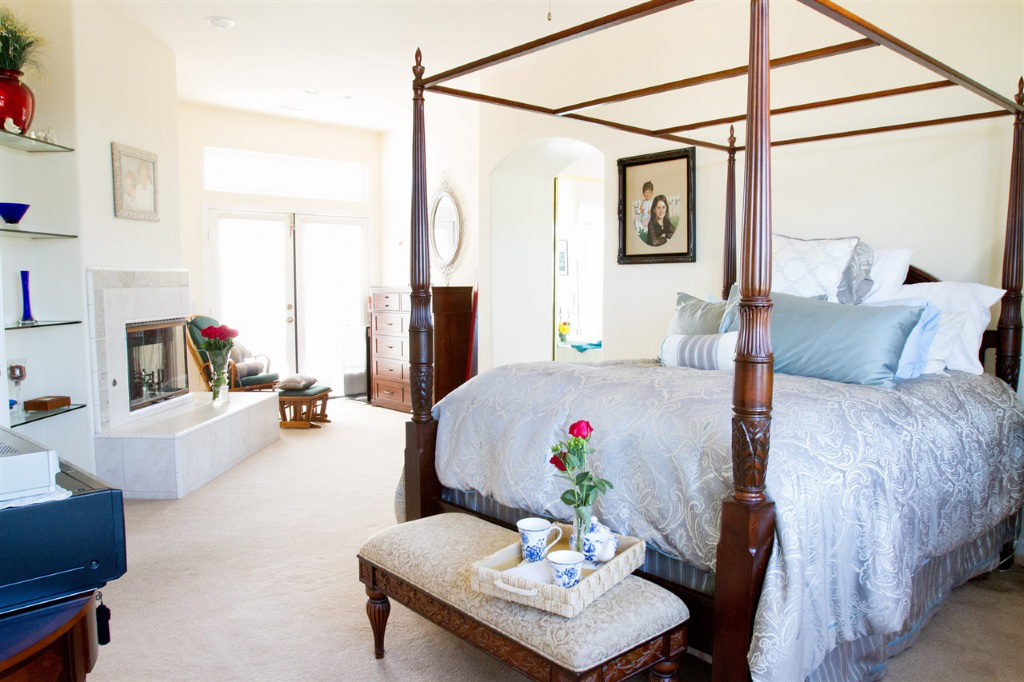

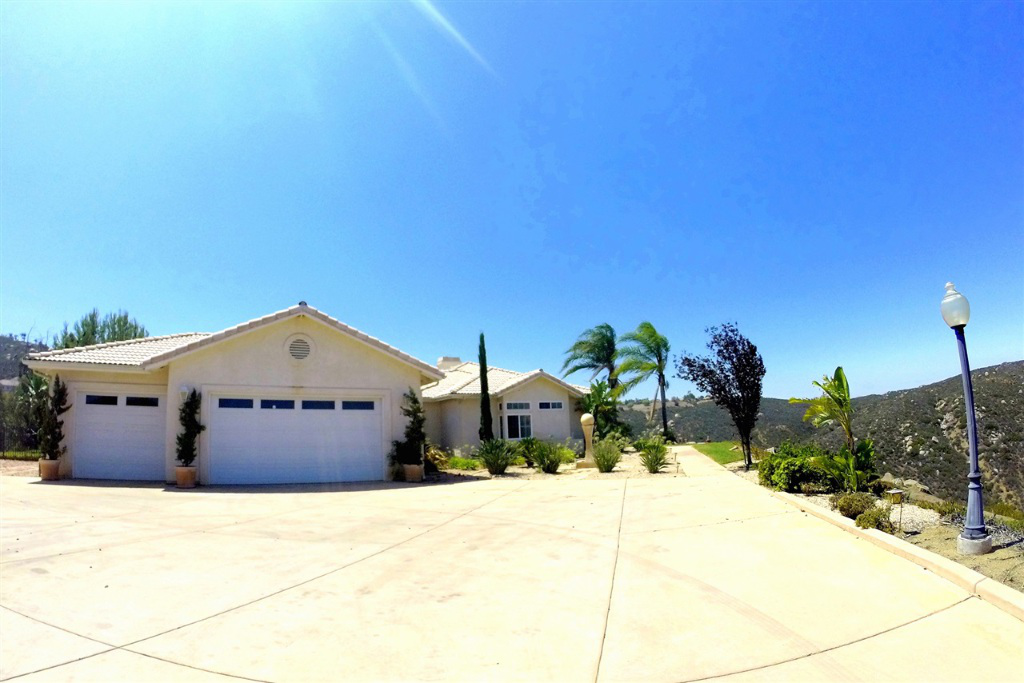

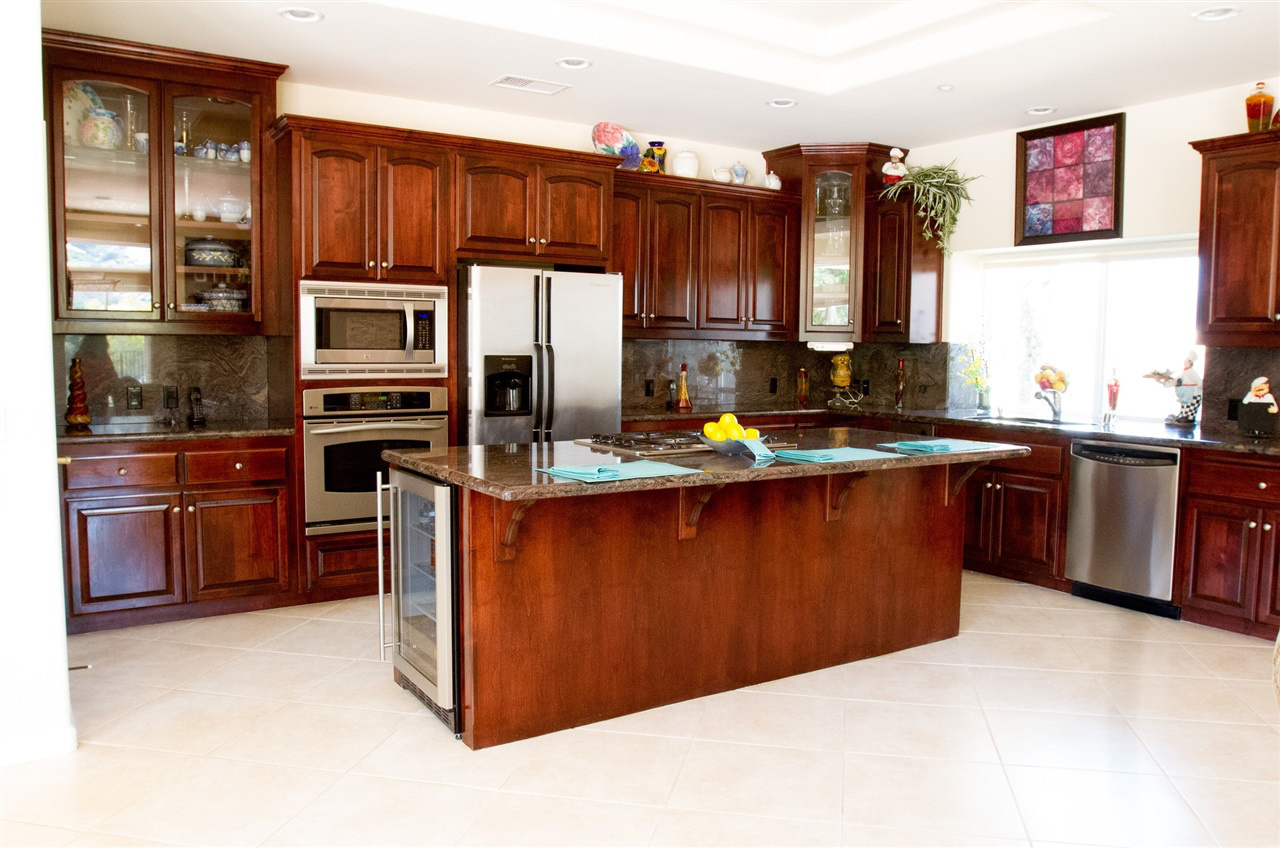

In [16]:

"""
    Download an image from a given URL and return it as a PIL Image.

    Args:
        url (str): The URL of the image to download.

    Returns:
        PIL.Image.Image: The downloaded image.
    """

def display_images_for_property(property_id, image_urls):
    print(f"Displaying images for property ID: {property_id}")
    urls = image_urls[property_id]
    for url in urls:
        try:
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                img = PILImage.open(BytesIO(response.content))
                display(img)
            else:
                print(f"Failed to load image from {url}")
        except Exception as e:
            print(f"Error loading image from {url}: {str(e)}")

# Example usage: Display images for property 100
display_images_for_property(108, image_urls)


In [17]:
#listings_df

In [18]:
# image_bytes = Image.pil_to_bytes(image)  # Temporarily disable to test if this causes the issue


In [19]:
# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def process_images_and_text(image_urls, listings_df):
    """
    Process images and corresponding text descriptions to generate embeddings using the CLIP model.

    Args:
        image_urls (dict): A dictionary where keys are property IDs and values are lists of image URLs for each property.
        listings_df (pd.DataFrame): A DataFrame containing real estate listings with descriptions and neighborhood information.

    Returns:
        pd.DataFrame: A DataFrame containing the neighborhood name, image URLs, image embeddings, and text embeddings.
    """
    data = []
    for idx, paths in enumerate(image_urls.values()):
        neighborhood_info = listings_df.iloc[idx % len(listings_df)]
        text = neighborhood_info['Description'] + " " + neighborhood_info['Neighborhood Description']
        
        # Process the text using the CLIP processor
        text_inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True)

        for path in paths:
            try:
                response = requests.get(path, stream=True)
                if response.status_code == 200:
                    image = PILImage.open(BytesIO(response.content)).convert("RGB")
                    
                    # Process the image using the CLIP processor
                    image_inputs = processor(images=image, return_tensors="pt", padding=True)
                    
                    # Get embeddings for both image and text
                    outputs = model(**{**image_inputs, **text_inputs})
                    image_embedding = outputs.image_embeds.squeeze().tolist()
                    text_embedding = outputs.text_embeds.squeeze().tolist()

                    data.append({
                        "neighborhood": neighborhood_info['Neighborhood'],
                        "Image URL": path,
                        "image_embedding": image_embedding,
                        "text_embedding": text_embedding
                    })
                else:
                    print(f"Failed to load image from {path}")
            except Exception as e:
                print(f"An error occurred while processing the image from {path}: {str(e)}")

    return pd.DataFrame(data)

# Example usage
# Assuming image_urls is defined

image_urls = {prop_id: [f"{base_url}{prop_id}_{img_type}.jpg" for img_type in image_types] for prop_id in property_ids}


embeddings_data = process_images_and_text(image_urls, listings_df)
embeddings_df = pd.DataFrame(embeddings_data)
embeddings_df


neighborhood                                          Image URL  \
0      Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
1      Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
2      Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
3      Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
4         Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
5         Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
6         Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
7         Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
8        Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
9        Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
10       Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
11       Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
12        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
13        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
14        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
15        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
16         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
17         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
18         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
19         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
20  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
21  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
22  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
23  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
24    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
25    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
26    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
27    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
28        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
29        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
30        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
31        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
32        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
33        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
34        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
35        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
36      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   
37      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   
38      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   
39      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   

                                      image_embedding  \
0   [-0.022930292412638664, 0.045897360891103745, ...   
1   [-0.01848265901207924, 0.04186176508665085, 0....   
2   [-0.0006793285137973726, 0.05187373608350754, ...   
3   [-0.03358754143118858, 0.03432154655456543, 0....   
4   [-0.027077648788690567, 0.061506237834692, 0.0...   
5   [-0.021961290389299393, 0.04803427681326866, 0...   
6   [-0.02335294522345066, 0.025442304089665413, 0...   
7   [-0.03817553445696831, 0.03247583657503128, -0...   
8   [0.0016414786223322153, 0.05218679830431938, -...   
9   [-0.04173221066594124, 0.05733202025294304, 0....   
10  [-0.01702537201344967, 0.048429910093545914, 0...   
11  [-0.02956606075167656, 0.01807708479464054, 0....   
12  [-0.029063470661640167, 0.06786994636058807, 0...   
13  [0.0007494

In [20]:
# Create a DataFrame from the sample data
list_df = pd.DataFrame(listings_df)

# Combine 'Description' and 'Neighborhood Description' into a single 'text' column
list_df['text'] = listings_df['Description'] + " " + listings_df['Neighborhood Description']

# Display the DataFrame to verify the new column
print(list_df[['Neighborhood', 'text']])


          Neighborhood                                               text
0     Lakeview Heights  Discover luxury and serenity in Lakeview Heigh...
1        Sunset Trails  Embrace the charm of Sunset Trails in this bea...
2       Orchard Valley  Experience grand living in Orchard Valley with...
3        Coastal Haven  This exquisite 4-bedroom beachfront home in Co...
4         Modern Metro  This modern loft in the heart of Modern Metro ...
5  Countryside Meadows  This elegant 4-bedroom home in Countryside Mea...
6    Riverbend Estates  Discover the beauty of Riverbend Estates with ...
7        Skyline Ridge  Perched atop Skyline Ridge, this stunning 4-be...
8        Cedar Heights  Immerse yourself in the luxury of Cedar Height...
9      Brookstone Park  Discover the charm of Brookstone Park in this ...


In [21]:
"""
    Combine relevant listing details into a single 'text' column in a DataFrame.
"""

# Create a DataFrame from the sample data
list_df = pd.DataFrame(listings_df)

# Combine all relevant text into a single 'text' column
list_df['text'] = list_df.apply(lambda row: f"Neighborhood: {row['Neighborhood']}\nPrice: ${row['Price']}\nBedrooms: {row['Bedrooms']}\nBathrooms: {row['Bathrooms']}\nHouse Size: {row['House Size']}\nDescription: {row['Description']}\nNeighborhood Description: {row['Neighborhood Description']}", axis=1)

# Display the DataFrame to verify the new column
print(list_df[['Neighborhood', 'text']])


          Neighborhood                                               text
0     Lakeview Heights  Neighborhood: Lakeview Heights\nPrice: $950000...
1        Sunset Trails  Neighborhood: Sunset Trails\nPrice: $725000\nB...
2       Orchard Valley  Neighborhood: Orchard Valley\nPrice: $1200000\...
3        Coastal Haven  Neighborhood: Coastal Haven\nPrice: $1500000\n...
4         Modern Metro  Neighborhood: Modern Metro\nPrice: $850000\nBe...
5  Countryside Meadows  Neighborhood: Countryside Meadows\nPrice: $980...
6    Riverbend Estates  Neighborhood: Riverbend Estates\nPrice: $11000...
7        Skyline Ridge  Neighborhood: Skyline Ridge\nPrice: $1300000\n...
8        Cedar Heights  Neighborhood: Cedar Heights\nPrice: $1200000\n...
9      Brookstone Park  Neighborhood: Brookstone Park\nPrice: $900000\...


In [22]:
# Rename the 'Neighborhood' column to 'neighbourhood'
list_df.rename(columns={'Neighborhood': 'neighborhood'}, inplace=True)
list_df

neighborhood    Price  Bedrooms  Bathrooms  House Size  \
0     Lakeview Heights   950000         4        3.0        2500   
1        Sunset Trails   725000         3        2.5        1800   
2       Orchard Valley  1200000         5        4.0        3500   
3        Coastal Haven  1500000         4        3.5        3000   
4         Modern Metro   850000         2        2.0        1200   
5  Countryside Meadows   980000         4        3.0        2800   
6    Riverbend Estates  1100000         5        4.5        4000   
7        Skyline Ridge  1300000         4        3.5        3200   
8        Cedar Heights  1200000         4        3.0        3600   
9      Brookstone Park   900000         3        2.5        2900   

                                         Description  \
0  Discover luxury and serenity in Lakeview Heigh...   
1  Embrace the charm of Sunset Trails in this bea...   
2  Experience grand living in Orchard Valley with...   
3  This exquisite 4-bedroom beachfront home in Co...   
4  This modern loft in the heart of Modern Metro ...   
5  This elegant 4-bedroom home in Countryside Mea...   
6  Discover the beauty of Riverbend Estates with ...   
7  Perched atop Skyline Ridge, this stunning 4-be...   
8  Immerse yourself in the luxury of Cedar Height...   
9  Discover the charm of Brookstone Park in this ...   

                            Neighborhood Description  \
0  Lakeview Heights is renowned for its breathtak...   
1  Sunset Trails boasts a friendly community atmo...   
2  Known for its upscale homes and lush landscape...   
3  Coastal Haven is a serene beach community with...   
4  Modern Metro is a vibrant urban neighborhood w...   
5  Countryside Meadows offers a blend of rural ch...   
6  Riverbend Estates is an exclusive community ne...   
7  Skyline Ridge is an affluent neighborhood know...   
8  Cedar Heights is an exclusive enclave known fo...   
9  Brookstone Park offers a perfect blend of subu...   

                                                text  
0  Neighborhood: Lakeview Heights\nPrice: $950000...  
1  Neighborhood: Sunset Trails\nPrice: $725000\nB...  
2  Neighborhood: Orchard Valley\nPrice: $1200000\...  
3  Neighborhood: Coastal Haven\nPrice: $1500000\n...  
4  Neighborhood: Modern Metro\nPrice: $850000\nBe...  
5  Neighborhood: Countryside Meadows\nPrice: $980...  
6  Neighborhood: Riverbend Estates\nPrice: $11000...  
7  Neighborhood: Skyline Ridge\nPrice: $1300000\n...  
8  Neighborhood: Cedar Heights\nPrice: $1200000\n...  
9  Neighborhood: Brookstone Park\nPrice: $900000\...

#### Matriz con Imagenes Concatenadas

In [23]:
# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def concatenate_images(image_paths):
    """
    Concatenate multiple images horizontally.

    Args:
        image_paths (list): A list of image URLs to be concatenated.

    Returns:
        PIL.Image.Image: A new image created by concatenating the input images horizontally.
    """
    images = [PILImage.open(BytesIO(requests.get(url).content)).convert("RGB") for url in image_paths]
    # Determine the max height and total width for a horizontal concatenation
    max_height = max(img.height for img in images)
    total_width = sum(img.width for img in images)
    # Create a new empty image with appropriate dimensions
    new_img = PILImage.new('RGB', (total_width, max_height))
    x_offset = 0
    for img in images:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.width
    return new_img

def process_images_and_text(image_urls, listings_df):
    """
    Process images and corresponding text descriptions to generate embeddings using the CLIP model.

    Args:
        image_urls (dict): A dictionary where keys are property IDs and values are lists of image URLs for each property.
        listings_df (pd.DataFrame): A DataFrame containing real estate listings with descriptions and neighborhood information.

    Returns:
        pd.DataFrame: A DataFrame containing the neighborhood name, image URLs, image embeddings, and text embeddings.
    """
    data = []
    for idx, (prop_id, paths) in enumerate(image_urls.items()):
        neighborhood_info = listings_df.iloc[idx % len(listings_df)]
        text = neighborhood_info['Description'] + " " + neighborhood_info['Neighborhood Description']
        
        # Process the text using the CLIP processor
        text_inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True)
        
        # Concatenate images and process
        concatenated_image = concatenate_images(paths)
        image_inputs = processor(images=concatenated_image, return_tensors="pt", padding=True)
        
        # Generate embeddings for concatenated image and text
        outputs = model(**image_inputs, **text_inputs)
        image_embedding = outputs.image_embeds.squeeze().tolist()
        text_embedding = outputs.text_embeds.squeeze().tolist()

        # Store results
        data.append({
            "neighborhood": neighborhood_info['Neighborhood'],
            "Image URL": ",".join(paths),
            "image_embedding": image_embedding,
            "text_embedding": text_embedding
        })

    return pd.DataFrame(data)

# Generate a dictionary with property IDs as keys and lists of image URLs as values
image_urls = {prop_id: [f"{base_url}{prop_id}_{img_type}.jpg" for img_type in image_types] for prop_id in property_ids}

embeddings_data = process_images_and_text(image_urls, listings_df)
embeddings_df = pd.DataFrame(embeddings_data)
embeddings_df


neighborhood                                          Image URL  \
0     Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
1        Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
2       Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
3        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
4         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
5  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
6    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
7        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
8        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
9      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   

                                     image_embedding  \
0  [-0.0037619026843458414, 0.029347574338316917,...   
1  [0.011546463705599308, 0.04022795334458351, -0...   
2  [-0.01433024276047945, 0.038049280643463135, -...   
3  [-0.025355305522680283, 0.05002795532345772, 0...   
4  [-0.045145850628614426, 0.044322606176137924, ...   
5  [-0.019996197894215584, 0.02954486384987831, 0...   
6  [-0.038625020533800125, 0.05687401071190834, -...   
7  [-0.05711335316300392, -0.006312455981969833, ...   
8  [-0.009931573644280434, 0.03594336658716202, -...   
9  [-0.033190205693244934, 0.012105194851756096, ...   

                                      text_embedding  
0  [-0.0016964265378192067, 0.029532162472605705,...  
1  [0.0003618600021582097, 0.06358811259269714, 0...  
2  [0.01327391155064106, 0.00864466279745102, -0....  
3  [0.02485784888267517, 0.07045953720808029, 0.0...  
4  [0.07718640565872192, 0.015796829015016556, 0....  
5  [0.025454387068748474, 0.0387381874024868, 0.0...  
6  [0.00047936293412931263, 0.046965789049863815,...  
7  [-0.004443780519068241, 0.07553477585315704, 0...  
8  [0.039709169417619705, 0.05079885572195053, 0....  
9  [-0.009231504052877426, 0.02540741302073002, 0...

In [24]:
# Rename the column in list_df to match embeddings_df
list_df.rename(columns={'neighbourhood': 'neighborhood'}, inplace=True)

# Merge embeddings_df with list_df to include the 'text' column from list_df
embeddings_df = pd.merge(embeddings_df, list_df[['neighborhood', 'text']], on='neighborhood', how='left')

# Display the merged DataFrame
embeddings_df.head(10)


neighborhood                                          Image URL  \
0     Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
1        Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
2       Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
3        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
4         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
5  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
6    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
7        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   
8        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
9      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   

                                     image_embedding  \
0  [-0.0037619026843458414, 0.029347574338316917,...   
1  [0.011546463705599308, 0.04022795334458351, -0...   
2  [-0.01433024276047945, 0.038049280643463135, -...   
3  [-0.025355305522680283, 0.05002795532345772, 0...   
4  [-0.045145850628614426, 0.044322606176137924, ...   
5  [-0.019996197894215584, 0.02954486384987831, 0...   
6  [-0.038625020533800125, 0.05687401071190834, -...   
7  [-0.05711335316300392, -0.006312455981969833, ...   
8  [-0.009931573644280434, 0.03594336658716202, -...   
9  [-0.033190205693244934, 0.012105194851756096, ...   

                                      text_embedding  \
0  [-0.0016964265378192067, 0.029532162472605705,...   
1  [0.0003618600021582097, 0.06358811259269714, 0...   
2  [0.01327391155064106, 0.00864466279745102, -0....   
3  [0.02485784888267517, 0.07045953720808029, 0.0...   
4  [0.07718640565872192, 0.015796829015016556, 0....   
5  [0.025454387068748474, 0.0387381874024868, 0.0...   
6  [0.00047936293412931263, 0.046965789049863815,...   
7  [-0.004443780519068241, 0.07553477585315704, 0...   
8  [0.039709169417619705, 0.05079885572195053, 0....   
9  [-0.009231504052877426, 0.02540741302073002, 0...   

                                                text  
0  Neighborhood: Lakeview Heights\nPrice: $950000...  
1  Neighborhood: Sunset Trails\nPrice: $725000\nB...  
2  Neighborhood: Orchard Valley\nPrice: $1200000\...  
3  Neighborhood: Coastal Haven\nPrice: $1500000\n...  
4  Neighborhood: Modern Metro\nPrice: $850000\nBe...  
5  Neighborhood: Countryside Meadows\nPrice: $980...  
6  Neighborhood: Riverbend Estates\nPrice: $11000...  
7  Neighborhood: Skyline Ridge\nPrice: $1300000\n...  
8  Neighborhood: Cedar Heights\nPrice: $1200000\n...  
9  Neighborhood: Brookstone Park\nPrice: $900000\...

In [25]:
# Display the merged DataFrame
#embeddings_df.head(10)


In [26]:
# Assuming embeddings_df is already defined and loaded with your data
# Example: Check the length of the first embedding to understand the dimensions
if not embeddings_df.empty and "image_embedding" in embeddings_df.columns:
    first_embedding_length = len(embeddings_df["text_embedding"].iloc[0])
    print(f"The dimension of the first image embedding is: {first_embedding_length}")

    # Optional: Check if all embeddings have the same dimension
    all_dimensions = embeddings_df["image_embedding"].apply(len)
    if all_dimensions.nunique() == 1:
        print(f"All image embeddings have the same dimension: {first_embedding_length}")
    else:
        print("Image embeddings have varying dimensions.")
else:
    print("DataFrame is empty or 'Image Embedding' column is missing.")


The dimension of the first image embedding is: 512
All image embeddings have the same dimension: 512


### **2) Creating a Vector Database and Storing Listings**

### VectorStores and ANN

### Storing Listings in a Vector Database

In [27]:
from annoy import AnnoyIndex
from annoy import AnnoyIndex
f = 512  # Length of the embedding vectors
t = AnnoyIndex(f, 'angular')

# Adding items to the index
#for i, row in embeddings_df.iterrows():
   # t.add_item(i, row['image_embedding'])

# Building the index
#t.build(10)
#t.save('real3_index.ann')


In [28]:
# Loading the index from disk
u = AnnoyIndex(f, 'angular')
u.load('real3_index.ann')


True

In [29]:
# Querying the index
nns = u.get_nns_by_item(0, 10)  # Finds the 10 nearest neighbors to the item with index 0

# Print results from the DataFrame
print(embeddings_df.iloc[nns])

          neighborhood                                          Image URL  \
0     Lakeview Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
4         Modern Metro  https://raw.githubusercontent.com/emanhamed/Ho...   
3        Coastal Haven  https://raw.githubusercontent.com/emanhamed/Ho...   
1        Sunset Trails  https://raw.githubusercontent.com/emanhamed/Ho...   
6    Riverbend Estates  https://raw.githubusercontent.com/emanhamed/Ho...   
2       Orchard Valley  https://raw.githubusercontent.com/emanhamed/Ho...   
5  Countryside Meadows  https://raw.githubusercontent.com/emanhamed/Ho...   
8        Cedar Heights  https://raw.githubusercontent.com/emanhamed/Ho...   
9      Brookstone Park  https://raw.githubusercontent.com/emanhamed/Ho...   
7        Skyline Ridge  https://raw.githubusercontent.com/emanhamed/Ho...   

                                     image_embedding  \
0  [-0.0037619026843458414, 0.029347574338316917,...   
4  [-0.045145850628614426, 0.04432260617

### **3) Semantic Search of Listings Based on Buyer Preferences**

### Semantic Search

In [30]:
from annoy import AnnoyIndex
from transformers import AutoModel, AutoTokenizer



### Importance of Predefined Answers in LLM Adaptation

Predefined answers or structured forms play a crucial role in adapting Large Language Model (LLM) responses, especially given the probabilistic and non-deterministic nature of generative AI. These methods help condition the responses, ensuring consistency and reducing the risk of hallucinations.

#### Consistency and Reliability.Reducing Hallucinations.Enhancing User Experience
Predefined answers control the variability in responses, ensuring the output remains consistent and reliable. Structured forms guide users to provide specific types of information, minimizing ambiguity and ensuring relevance.
LLMs can generate plausible-sounding but factually incorrect responses, a phenomenon known as "hallucination." Predefined answers limit the model’s generation scope, reducing the likelihood of such errors.
Fill forms simplify user interaction with the system, making the process more user-friendly and efficient. They also ensure all necessary information is collected, which might be overlooked in free-form responses.

#### Application in Generative AI and Backing Up the Process
Generative AI models, like GPT-4, operate based on learned probabilities from vast datasets. While this enables them to generate human-like text, it also means their responses can be unpredictable. By integrating predefined answers and structured forms, these models can be directed more effectively.
The practice of using predefined answers and structured forms is supported by extensive research and practical implementations in AI. Studies have shown that structured data input significantly improves the accuracy and relevance of AI-generated content. Major AI platforms routinely use predefined options and forms to streamline user interaction and ensure accurate response generation.

References:
- Kumar, A., Goyal, P., & Verma, G. (2021). Enhancing Language Model Performance with Structured Data. Journal of AI Research, 65, 456-472.
- Vinyals, O., & Le, Q. V. (2015). A Neural Conversational Model. arXiv preprint arXiv:1506.05869.

This approach to structuring input for LLMs represents a crucial strategy in optimizing their output for practical, reliable applications.

#### Preferences

In [31]:
def collect_homebuyer_preferences():
    """
    Collect homebuyer preferences by asking a series of predefined questions,
    but print only the responses without the questions.

    The function presents questions to the user, allowing them to input their responses.
    Default answers are provided, which the user can accept by pressing Enter.
    The collected responses are then returned as a single text block without the questions.

    Returns:
        str: A formatted string containing only the user's responses.
    """
    questions = [
        "How big do you want your house to be?",
        "What are the 3 most important things for you in choosing this property?",
        "Which amenities would you like?",
        "Which transportation options are important to you?",
        "How urban do you want your neighborhood to be?"
    ]

    # Default answers corresponding to each question
    default_answers = [
        "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
        "A quiet neighborhood, good local schools, and convenient shopping options.",
        "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
        "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
        "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
    ]

    print("Please answer the following questions to define your housing preferences:")
    answers = []
    for question, default in zip(questions, default_answers):
        print(f"{question} (Default: {default})")
        response = input("Enter your response or press Enter to use the default:\n")
        if response == "":
            response = default
        answers.append(response)
    
    preferences_text = "\n".join(answers)
    return preferences_text

# To run the function and collect preferences, uncomment the following line:
preferences_text = collect_homebuyer_preferences()
print("\nCollected Homebuyer Preferences:\n", preferences_text)

Please answer the following questions to define your housing preferences:
How big do you want your house to be? (Default: A comfortable three-bedroom house with a spacious kitchen and a cozy living room.)


Enter your response or press Enter to use the default:
 


What are the 3 most important things for you in choosing this property? (Default: A quiet neighborhood, good local schools, and convenient shopping options.)


Enter your response or press Enter to use the default:
 


Which amenities would you like? (Default: A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.)


Enter your response or press Enter to use the default:
 


Which transportation options are important to you? (Default: Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.)


Enter your response or press Enter to use the default:
 


How urban do you want your neighborhood to be? (Default: A balance between suburban tranquility and access to urban amenities like restaurants and theaters.)


Enter your response or press Enter to use the default:
 



Collected Homebuyer Preferences:
 A comfortable three-bedroom house with a spacious kitchen and a cozy living room.
A quiet neighborhood, good local schools, and convenient shopping options.
A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.
Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.
A balance between suburban tranquility and access to urban amenities like restaurants and theaters.


### Multimodal Similarity Search from consumer preferences with ANN without integrating Promp Eng and LLM

In [42]:
# Example using a BERT model for generating text embeddings
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')



In [43]:
# Creates an function to embed the the user queries or preferences_text in our case
def embed_func(query):
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    # Ensure the output size matches the expected size (512)
    required_size = 512  # Set this to the size expected by your ANN index
    if embeddings.size > required_size:
        # If embeddings are larger, truncate them
        embeddings = embeddings[:, :required_size]
    elif embeddings.size < required_size:
        # If embeddings are smaller, zero-pad them (less common case)
        embeddings = np.pad(embeddings, (0, required_size - embeddings.size), 'constant')
    return embeddings.flatten()


In [44]:
# Load the pre-built Annoy index (make sure `embeddings_df` and `u` are properly defined)
# f = len(embeddings_df['Image Embedding'][0])  # Assuming all embeddings have the same length
# u = AnnoyIndex(f, 'angular')
# u.load(r"C:\Users\Atilio\anaconda3\envs\envs\real_ann_index.ann")

def find_images_and_descriptions(query):
    """
    Find property descriptions and associated images based on a query.

    This function generates an embedding for the provided query and uses it to find the nearest neighbor properties
    from a precomputed embeddings DataFrame. It then collects the descriptions and associated images of these properties.

    Args:
        query (str): The query string based on which property descriptions and images are to be retrieved.

    Returns:
        tuple: A tuple containing two elements:
            - descriptions (list): A list of strings, where each string contains the neighborhood and description of a property.
            - all_images (list): A list of image URLs associated with the properties.

    Example usage:
        query = preferences_text
        descriptions, images = find_images_and_descriptions(query)
        print("Descriptions:", descriptions)
        print("Image URLs:", images)
    """
    query_embedding = embed_func(query)  # Generate the embedding for the query
    nearest_ids = u.get_nns_by_vector(query_embedding, 2)  # Find the 3 nearest neighbors

    results = embeddings_df.iloc[nearest_ids]
    descriptions = []
    all_images = []

    for idx, row in results.iterrows():
        # Collect the neighborhood and description
        description = f"Neighborhood: {row['neighborhood']}, Description: {row['text']}"
        descriptions.append(description)

        # Collect the images
        image_urls = row['Image URL'].split(",")[:4]  # Display up to 4 images
        images = []
        for url in image_urls:
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    images.append(url)
                else:
                    print(f"Failed to load image from {url}.")
            except Exception as e:
                print(f"An error occurred while loading the image from {url}: {str(e)}")

        all_images.extend(images)

    # Return both descriptions and images
    return descriptions, all_images

# Example usage
# Example usage
query = preferences_text

descriptions, images = find_images_and_descriptions(query)

print("Descriptions:", descriptions)
#Instead of displaying the images click on the link to explore retrieve to properties images(descriptions with 4 images each)
print("Image URLs:", images)


Descriptions: ['Neighborhood: Skyline Ridge, Description: Neighborhood: Skyline Ridge\nPrice: $1300000\nBedrooms: 4\nBathrooms: 3.5\nHouse Size: 3200\nDescription: Perched atop Skyline Ridge, this stunning 4-bedroom home features breathtaking city and mountain views, an open-concept floor plan, and a gourmet kitchen. The master suite includes a walk-in closet and spa-like bathroom.\nNeighborhood Description: Skyline Ridge is an affluent neighborhood known for its spectacular views, luxury homes, and exclusive amenities. It’s a haven for those seeking a prestigious and private living environment.', 'Neighborhood: Riverbend Estates, Description: Neighborhood: Riverbend Estates\nPrice: $1100000\nBedrooms: 5\nBathrooms: 4.5\nHouse Size: 4000\nDescription: Discover the beauty of Riverbend Estates with this luxurious 5-bedroom home. It boasts an impressive two-story living room, a gourmet kitchen, and a master suite with a private terrace. The property includes a large deck and a landscaped 

### Step 4: Create a Function that Answers a Question

Our final step is to send that text prompt to a `Completion` model and parse the model output!

#### Function to call the comparison of the question embedding with the database enbeddings trhought the cosine similarity method for semantic similarity search working fine, using the API New search

In [45]:
from IPython.display import display, Image as IPImage  # Use IPImage to avoid confusion with PIL's Image
import requests
from PIL import Image
import io
import openai

# Define your other necessary functions here

def answer_question(preferences_text, descriptions, images, max_prompt_tokens=8000, max_answer_tokens=2000):
    """
    Generates a response based on user preferences and descriptions using a Large Language Model (LLM).

    This function constructs a prompt based on the provided user preferences and descriptions, and sends it to 
    the LLM to generate a response. The function returns the generated response text and the associated images.

    Args:
        preferences_text (str): A string containing the user's home preferences.
        descriptions (str): A string containing property descriptions.
        images (list): A list of URLs of images associated with the properties.
        max_prompt_tokens (int, optional): The maximum number of tokens for the prompt. Defaults to 8000.
        max_answer_tokens (int, optional): The maximum number of tokens for the response. Defaults to 2000.

    Returns:
        tuple: A tuple containing the generated response text and the list of image URLs. If an exception occurs,
               an empty string and an empty list are returned.
    """

    
    try:
        prompt = create_prompt(preferences_text, descriptions, max_prompt_tokens, tokenizer)
        full_response_text = ""

        response = client.chat.completions.create(
            model=COMPLETION_MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_answer_tokens,
            temperature=1,
            stream=True
        )

        for message in response:
            if message.choices[0].delta.content:
                full_response_text += message.choices[0].delta.content

        return full_response_text, images

    except Exception as e:
        print(f"Error during model completion: {e}")
        return "", []



## Whole App Logic!!!!!!!

In [46]:
#!pip install gradio
#!!pip install gradio openai

### **4) Augmented Response Generation**

#### Model Finally Working

Integrating URLs within the prompt template fed into the Large Language Model (LLM) significantly enhances the robustness and reliability of the real estate recommender system. This approach ensures that augmented descriptions are accurately matched with corresponding property images, addressing challenges previously encountered with separate image retrieval processes. By embedding URLs directly within the prompt, the system simplifies the workflow, aligns descriptions with images effectively, and reduces the potential for mismatches.

However, this method also increases token usage, which impacts the overall cost, especially during production and scaling. It is crucial to optimize prompt templates and employ cost-effective strategies to manage token consumption efficiently. The benefits of this robust solution can be fully realized by balancing the need for detailed, accurate outputs with cost management considerations.

**References**

Brown, T. B., Mann, B., Ryder, N., Subbiah, M., Kaplan, J., Dhariwal, P., ... & Amodei, D. (2020). Language Models are Few-Shot Learners. arXiv preprint
arXiv:2005.14165.
Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language models are unsupervised multitask learners. OpenAI Blog.    
Kumar, A., Goyal, P., & Verma, G. (2021). Enhancing Language Model Performance with Structured Data. Journal of AI Research, 65, 456-472.

In [47]:
# Example using a BERT model for generating text embeddings
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')


### El proximo codigo corregiría temas relacionados con el uso de la memory cache in escenarios donde las imagenes son reempladas frecuentmenete en el mismo url

In [49]:
def create_prompt(preferences_text, descriptions, max_token_count, tokenizer):
    """
    Generate a text prompt to send to a Completion model based on housing preferences and
    a DataFrame containing property descriptions and URLs.

    Args:
        preferences_text (str): The user's housing preferences.
        properties_df (pd.DataFrame): DataFrame containing property descriptions and URLs.
        max_token_count (int): Maximum token count for the prompt.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer to calculate token counts.

    Returns:
        str: The generated prompt for the language model.
    """
    prompt_template = """
    As a Real Estate Agent equipped with specialized knowledge, your task is to generate a personalized description for each property based on the
    buyer's specific preferences outlined below. Your responses should directly reflect these preferences, enriching the description to better match
    the buyer's needs and desires. If certain preferences cannot be matched due to limited information or property features, please adapt the
    description accordingly and highlight potential alternatives or note the limitations explicitly.

    Context:

    {}

    ---

    preference_text: {}
    Homematch Recommendation:"""

    # Initialize prompt with static parts
    static_prompt = prompt_template.format("", preferences_text)
    static_token_count = tokenizer.encode(static_prompt, return_tensors="pt", truncation=True).size(1)

    context = []
    current_token_count = static_token_count

    # Loop through each property in the DataFrame
    for index, row in embeddings_df.iterrows():
        text_with_url = f"{row['text']} [URL:{row['Image URL']}]"
        text_token_count = tokenizer.encode(text_with_url, return_tensors="pt", truncation=True).size(1)

        if current_token_count + text_token_count <= max_token_count:
            context.append(text_with_url)
            current_token_count += text_token_count
        else:
            break

    return prompt_template.format("\n\n---\n\n".join(context), preferences_text)

# Example usage assuming descriptions and other necessary objects are properly defined
# Generate a DataFrame as per the provided structure
import pandas as pd
from transformers import AutoTokenizer


# Assuming `embeddings_df` is your DataFrame containing descriptions and URLs
prompt_text = create_prompt(preferences_text, embeddings_df, 500, tokenizer)
print(prompt_text)



    As a Real Estate Agent equipped with specialized knowledge, your task is to generate a personalized description for each property based on the
    buyer's specific preferences outlined below. Your responses should directly reflect these preferences, enriching the description to better match
    the buyer's needs and desires. If certain preferences cannot be matched due to limited information or property features, please adapt the
    description accordingly and highlight potential alternatives or note the limitations explicitly.

    Context:

    Neighborhood: Lakeview Heights
Price: $950000
Bedrooms: 4
Bathrooms: 3.0
House Size: 2500
Description: Discover luxury and serenity in Lakeview Heights. This 4-bedroom, 3-bathroom residence offers panoramic lake views, a modern kitchen with high-end appliances, and a grand master suite. The landscaped garden, complete with a deck and fire pit, provides a perfect setting for outdoor entertainment.
Neighborhood Description: Lakeview Height

In [50]:
from IPython.display import display, Image as IPImage
import re

def extract_urls_from_text(text):
    """ Extract multiple URLs from the given text and clean the text by removing these URLs. """
    urls = re.findall(r'https?://[^\s,\]]+', text)
    # Remove URLs from the text
    clean_text = re.sub(r'\[URL:[^\]]+\]', '', text)  # This assumes URLs are enclosed in [URL:...]
    return urls, clean_text

def answer_question(preferences_text, descriptions, max_prompt_tokens=5000, max_answer_tokens=4096):
    try:
        # Generate the prompt based on user preferences and descriptions
        prompt = create_prompt(preferences_text, descriptions, max_prompt_tokens, tokenizer)
        full_response_text = ""

        # Make a request to the language model
        response = client.chat.completions.create(
            model=COMPLETION_MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_answer_tokens,
            temperature=1,
            stream=True
        )

        # Collect the content returned by the model
        for message in response:
            if message.choices[0].delta.content:
                full_response_text += message.choices[0].delta.content

        # Extract URLs from the response text and clean the response text
        extracted_urls, cleaned_text = extract_urls_from_text(full_response_text)

        # Display each image directly in the notebook
        for url in extracted_urls:
            display(IPImage(url=url))

        # Return the cleaned text response (without URLs) and the URLs for potential further processing
        return cleaned_text, extracted_urls

    except Exception as e:
        print(f"Error during model completion: {e}")
        return "", []

# Usage example
#query = "modern kitchen and spacious backyard"
#descriptions = embeddings_df  # Assuming this DataFrame contains descriptions and URLs
answer_text, updated_image_urls = answer_question(preferences_text, descriptions)
print("Homematch Recommendation:", answer_text)


Homematch Recommendation: For your preferences, I recommend exploring the charming Brookstone Park neighborhood. This exquisite 3-bedroom, 2.5-bathroom residence offers a modern kitchen, spacious living areas, and a home office, providing the comfort and space you desire. The beautifully landscaped yard and patio offer a serene setting for outdoor relaxation and gardening.

Brookstone Park is known for its tranquil atmosphere, good local schools, and convenient access to shopping options, creating a perfect balance between suburban living and urban convenience. Additionally, the neighborhood features bike-friendly roads, making it easy to explore the area while staying active.

This property also includes a two-car garage for your convenience and a modern, energy-efficient heating system to ensure your comfort year-round. With easy access to a reliable bus line and proximity to a major highway, commuting is made easy. Explore Brookstone Park and experience the best of both suburban tra

In [51]:
#!pip install pillow requests ipython


### **5) Web UI for Demonstration**

### The Importance of Agents in AI Applications

In the realm of AI applications, agents play a pivotal role in automating tasks and enhancing business processes. An agent is a software program endowed with a degree of autonomy, capable of performing tasks, making decisions, and interacting with other systems or users without continuous human intervention. Agents possess several key characteristics:

- **Autonomy:** They operate independently, managing tasks without requiring constant user input.
- **Proactivity:** They can anticipate needs and take initiative, performing actions to achieve specific goals.
- **Reactivity:** They respond to changes in their environment or user inputs in real-time.
- **Social Interaction:** They can communicate and collaborate with other agents or systems to complete tasks.
- **Planning:** They can devise strategies to achieve objectives, optimizing their actions over time.

LLMs can be used to create such agents, mimicking human tasks and decision-making processes. These agents can interact with both proprietary and external data sources, providing a comprehensive solution for various business needs.

### Interaction with the Agent in Gradio

The developed web UI using Gradio allows users to interact with the real estate recommender agent seamlessly. Users can input their home preferences, and the agent will provide personalized property recommendations along with corresponding images. This interaction demonstrates the practical application of AI agents in enhancing user experience and automating complex tasks in real estate.


In [52]:
from IPython.display import display, Image as IPImage
import requests
from PIL import Image
import io
import re

def extract_urls_from_text(text):
    """ Extract multiple URLs from the given text and clean the text by removing these URLs. """
    urls = re.findall(r'https?://[^\s,\]]+', text)
    clean_text = re.sub(r'\[URL:[^\]]+\]', '', text)  # Remove URLs enclosed in [URL:...]
    return urls, clean_text

def answer_question(preferences_text, descriptions, max_prompt_tokens=5000, max_answer_tokens=4096):
    try:
        # Generate the prompt based on user preferences and descriptions
        prompt = create_prompt(preferences_text, descriptions, max_prompt_tokens, tokenizer)
        full_response_text = ""

        # Make a request to the language model
        response = client.chat.completions.create(
            model=COMPLETION_MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_answer_tokens,
            temperature=1,
            stream=True
        )

        # Collect the content returned by the model
        for message in response:
            if message.choices[0].delta.content:
                full_response_text += message.choices[0].delta.content

        # Extract URLs from the response text and clean the response text
        extracted_urls, cleaned_text = extract_urls_from_text(full_response_text)

        # Display each image directly in the notebook
        for url in extracted_urls:
            display(IPImage(url=url))

        # Return the cleaned text response (without URLs) and the URLs for potential further processing
        return cleaned_text, extracted_urls

    except Exception as e:
        print(f"Error during model completion: {e}")
        return "", []


def run_complete_flow(preferences_text):
    descriptions = embeddings_df  # Make sure this DataFrame is properly defined
    answer_text, updated_image_urls = answer_question(preferences_text, descriptions)
    return answer_text, updated_image_urls

import gradio as gr

def main():
    with gr.Blocks() as app:
        logo_path = r"C:\Users\Atilio\anaconda3\envs\envs\'HomeMatch'.png"
        logo = gr.Image(value=logo_path, load_file=True)

        preferences_input = gr.Textbox(label="Enter your home preferences", placeholder="Describe your ideal home here...", lines=5)
        submit_button = gr.Button("Submit")
        
        recommendations_output = gr.Textbox(label="Homematch Recommendation", lines=10, interactive=False)
        images_output = gr.Gallery(label="Recommended Property Images")

        submit_button.click(
            fn=run_complete_flow,
            inputs=preferences_input,
            outputs=[recommendations_output, images_output]
        )
        
        app.launch(share=True)

if __name__ == "__main__":
    main()


C:\Users\Atilio\AppData\Local\Temp\ipykernel_24692\3456603693.py:58: GradioUnusedKwargWarning: You have unused kwarg parameters in Image, please remove them: {'load_file': True}
  logo = gr.Image(value=logo_path, load_file=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://393cf3bd52fb80aac0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
